In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("features/features_train.csv")

In [4]:
sns.pairplot(data=df, hue="melanoma", diag_kind="kde", diag_kws={"common_norm": False})

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f09db70bb80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt: 


KeyboardInterrupt: 

KeyboardInterrupt: 

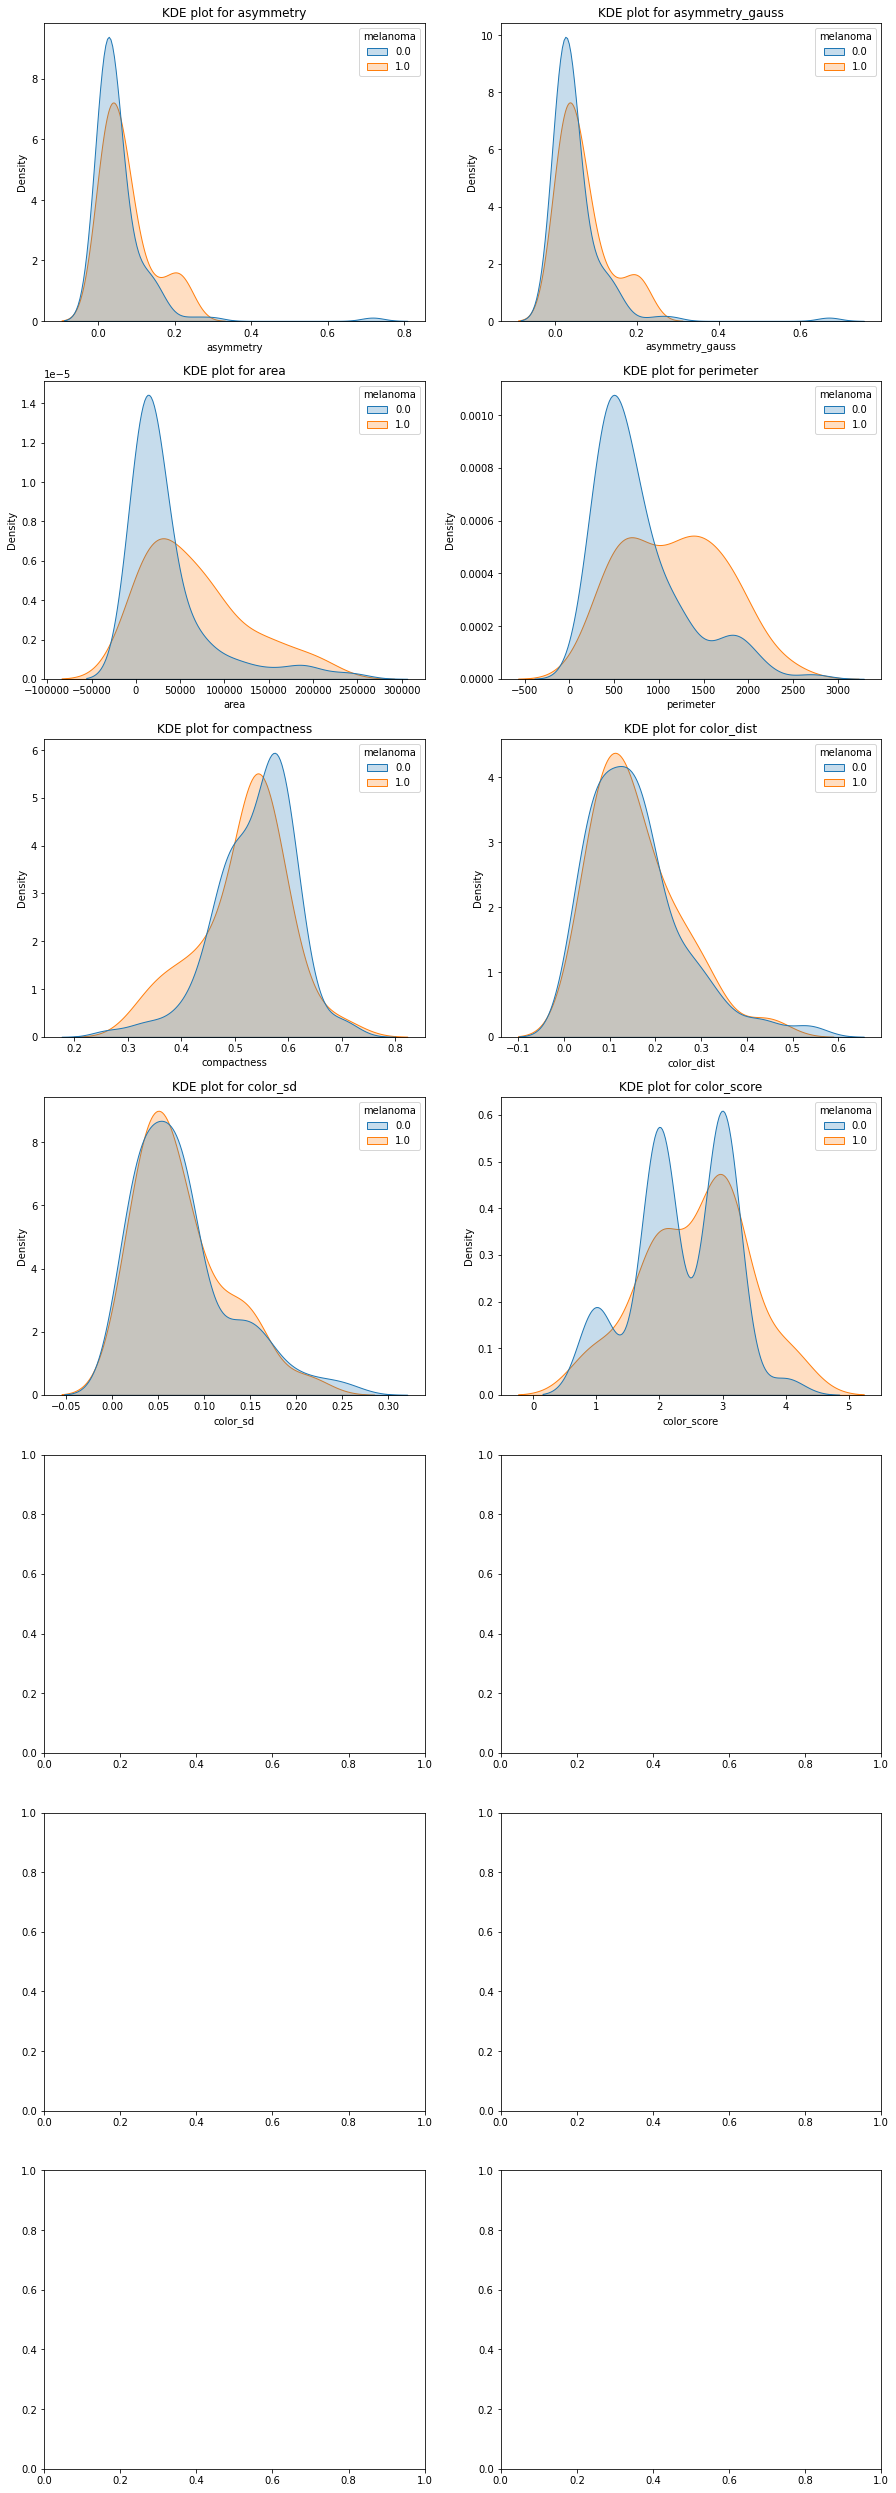

In [6]:
fig, axes = plt.subplots(7, 2, figsize=(15, 45))
features = list(df)[2:]
for feature, ax in zip(features, axes.flatten()):
    sns.kdeplot(feature, data=df, hue="melanoma", fill=True, common_norm=False, ax=ax)
    ax.set_title(f"KDE plot for {feature}")

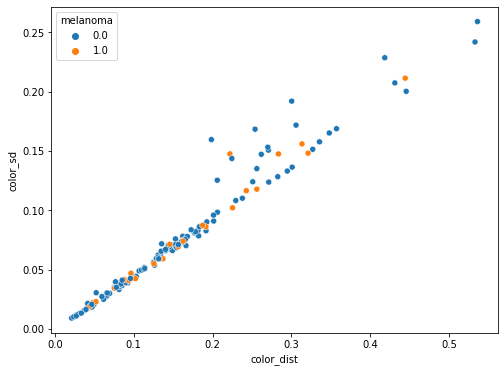

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x="color_dist", y="color_sd", hue="melanoma", data=df, ax=ax);

In [8]:
pearsonr(df["color_dist"], df["color_sd"])

(0.9791019388601951, 2.828854982062931e-104)

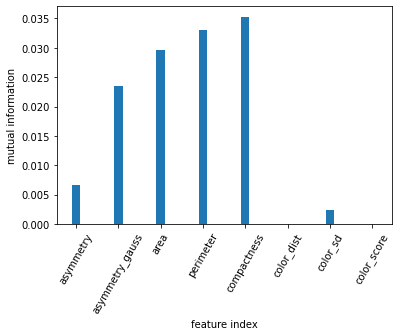

In [9]:
df = pd.read_csv("features/features.csv")
X = df.drop(["image_id", "melanoma"], axis=1).to_numpy()
y = np.array(df["melanoma"])
feature_names = [
    "asymmetry",
    "asymmetry_gauss",
    "area",
    "perimeter",
    "compactness",
    "color_dist",
    "color_sd",
    "color_score",
]
selector = SelectKBest(mutual_info_classif, k=4)
selector.fit(X, y)

# Show the feature scores
scores = selector.scores_


fig, ax = plt.subplots()
ax.bar(feature_names, scores, width=.2)
ax.set_xlabel('feature index')
ax.set_ylabel('mutual information')
plt.xticks(rotation=60);

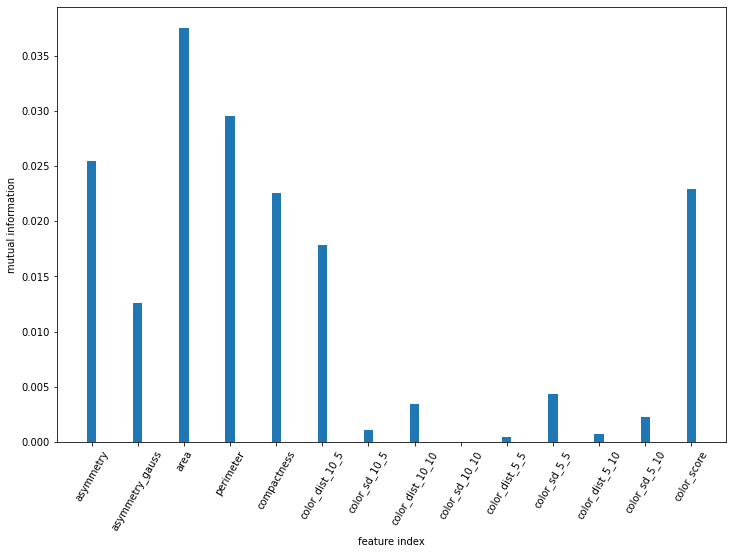

In [10]:
from sklearn.feature_selection import chi2
df = pd.read_csv("features/features_train.csv")
X = df.drop(["image_id", "melanoma"], axis=1)
y = df["melanoma"]
# feature_names = [
#     "asymmetry",
#     "asymmetry_gauss",
#     "area",
#     "perimeter",
#     "compactness",
#     "color_dist",
#     "color_sd",
#     "color_score",
# ]
feature_names = list(df)[2:]
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X, y)

# Show the feature scores
scores = selector.scores_


fig, ax = plt.subplots(figsize=(12,8))
ax.bar(feature_names, scores, width=.2)
ax.set_xlabel('feature index')
ax.set_ylabel('mutual information')
plt.xticks(rotation=60);

KNN Accuracy scores
acc_score: 0.806 ±0.01
auc_score: 0.664 ±0.02
______________________________
Decision Tree Accuracy scores
acc_score: 0.806 ±0.01
auc_score: 0.664 ±0.01

Confusion matrix for threshold 0.3
[[0.80153846 0.19846154]
 [0.58133333 0.41866667]]


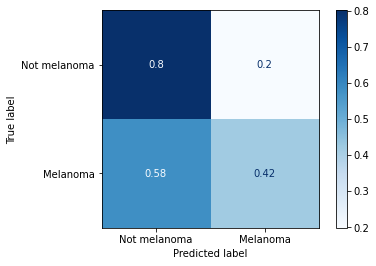

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv("features/features_train.csv")
jdf = pd.read_csv("features/json_features_training.csv")
features = ["asymmetry", "area", "perimeter", "compactness", "color_dist_10_5", "color_score"]
x = df[features].to_numpy()
# x = df.drop(["image_id", "melanoma"], axis=1).to_numpy()

scaler = StandardScaler().fit(x)
x = scaler.transform(x)

# x = np.c_[x, jdf.drop(["image_id", "melanoma"], axis=1).to_numpy()]
y = np.array(df["melanoma"])

# Testing removing some non-melanoma samples
# non_mel_indices = np.where(y == 0)[0]
# mel_indices = np.where(y == 1)[0]
# picks = np.random.default_rng(seed=1).choice(non_mel_indices, size=(len(non_mel_indices) // 2), replace=False)
# x = x[np.r_[picks, mel_indices]]
# y = y[np.r_[picks, mel_indices]]

n_splits = 10
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val_knn = np.empty((n_splits, 1))
auc_val_knn = np.empty((n_splits, 1))
acc_val_tree = np.empty((n_splits, 1))
auc_val_tree = np.empty((n_splits, 1))

k = 9
threshold = 0.3


# fig, axes = plt.subplots(1, n_splits, figsize=(25,5))


conf_mats = []

for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]
    # display = RocCurveDisplay.from_estimator(clf, x_val, y_val, ax=axes[i])
    
    acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
    auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

    conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]

    acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
    auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    

    

print("KNN Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
print("_"*30)
print("Decision Tree Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_tree):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_tree):.2f}")

print(f"\nConfusion matrix for threshold {threshold}")
conf_mats = np.stack(conf_mats, axis=2)
avg_conf_mat = np.mean(conf_mats, axis=2)
avg_conf_mat = normalize(avg_conf_mat, norm="l1")
print(avg_conf_mat)
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
display.plot(cmap=plt.cm.Blues);


In [12]:
n_features = 6

In [13]:
n_features = 3

In [14]:
df = pd.read_csv("features/features_train.csv")
x_train = df.drop(["image_id", "melanoma"], axis=1).to_numpy()
feature_names = np.array(list(df)[2:])
y = np.array(df["melanoma"])
clf = KNeighborsClassifier(n_neighbors=5)
kf = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=1)
# n_features = 7

selector = SequentialFeatureSelector(clf, n_features_to_select=n_features, direction="forward", cv=kf)
sfs_forward = selector.fit(x_train, y)
print("Forward selected features")
print(feature_names[sfs_forward.get_support()])
print()

selector = SequentialFeatureSelector(clf, n_features_to_select=n_features, direction="backward", cv=kf)
sfs_backward = selector.fit(x_train, y)
print("Backwards selected features")
print(feature_names[sfs_backward.get_support()])
print()

features_fb = [feature_names[sfs.get_support()] for sfs in [sfs_forward, sfs_backward]]

for j, features in enumerate(features_fb):
    x = df[features].to_numpy()
    acc_val_knn = np.empty((n_splits, 1))
    auc_val_knn = np.empty((n_splits, 1))
    acc_val_tree = np.empty((n_splits, 1))
    auc_val_tree = np.empty((n_splits, 1))

    k = 5

    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = KNeighborsClassifier(n_neighbors=k)
        clf = clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]
        
        acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
        auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

        clf = DecisionTreeClassifier(random_state=1)
        clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]

        acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
        auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    
    strings = [f"Forward selection of {n_features} features", f"Backwards selection of {n_features} features"]
    print(strings[j])
    print("KNN Accuracy scores")
    print("acc_score:", np.mean(acc_val_knn))
    print("auc_score:", np.mean(auc_val_knn))
    print("_"*30)
    print("Decision Tree Accuracy scores")
    print("acc_score:", np.mean(acc_val_tree))
    print("auc_score:", np.mean(auc_val_tree))
    print("\n")

Forward selected features
['compactness' 'color_dist_10_5' 'color_dist_5_5']

Backwards selected features
['area' 'perimeter' 'color_score']

Forward selection of 3 features
KNN Accuracy scores
acc_score: 0.39612499999999995
auc_score: 0.6757711538461539
______________________________
Decision Tree Accuracy scores
acc_score: 0.6871591025641026
auc_score: 0.6279711538461538


Backwards selection of 3 features
KNN Accuracy scores
acc_score: 0.6725288461538461
auc_score: 0.2983076923076923
______________________________
Decision Tree Accuracy scores
acc_score: 0.764125
auc_score: 0.6079764102564102




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6840a14b-d41a-45b9-abd0-892354334cb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>